# DTTrans: MLP

In [1]:
import numpy as np
import pandas as pd
import math

from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus
from datetime import datetime
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # type: ignore
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = True # type: ignore

seed_everything(42)

In [3]:
## load Delaunay Triangulation result
del_result_path = r'D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\PV_delaunay_tri(bell)_20211028_updated.csv' # 들로네 삼각분할 결과 => But, 21.10.28일까지의 PV 사이트에 대한 Update 필요!
del_pv = pd.read_csv(del_result_path)

del_pv.head()

## Union-Inner Triangles Algorithm

In [3]:
# Python3 code to find all three angles
# of a triangle given coordinate
# of all three vertices
import math

# returns square of distance b/w two points
def lengthSquare(X, Y):
    xDiff = X[0] - Y[0]
    yDiff = X[1] - Y[1]
    return xDiff * xDiff + yDiff * yDiff

def getAngle(A, B, C):
    # Square of lengths be a2, b2, c2
    a2 = lengthSquare(B, C)
    b2 = lengthSquare(A, C)
    c2 = lengthSquare(A, B)

    # length of sides be a, b, c
    a = math.sqrt(a2)
    b = math.sqrt(b2)
    c = math.sqrt(c2)

    # From Cosine law
    alpha = math.acos((b2 + c2 - a2) /
                         (2 * b * c))
    betta = math.acos((a2 + c2 - b2) /
                         (2 * a * c))
    gamma = math.acos((a2 + b2 - c2) /
                         (2 * a * b))

    # Converting to degree
    alpha = alpha * 180 / math.pi
    betta = betta * 180 / math.pi
    gamma = gamma * 180 / math.pi
    
    return [alpha, betta, gamma]

In [4]:
pv_not_del_3weathers = []

del_pv.reset_index(drop=True, inplace=True)
for i in range(len(del_pv)):
    euclidean_dist_result = pd.read_csv(r"D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\Expection_result\each_PV_weather_dist_euclidean/"+
                                      "PV_"+del_pv["발전기명"][i]+"_dist_weather.csv")
                                      
    euclidean_3weathers = [euclidean_dist_result['지점번호'][0], euclidean_dist_result['지점번호'][1], euclidean_dist_result['지점번호'][2]]
    euclidean_3weathers.sort()

    del_3weathers  = [del_pv[del_pv['발전기명']== del_pv["발전기명"][i]]['지점번호0'].values[0], del_pv[del_pv['발전기명']== del_pv["발전기명"][i]]['지점번호1'].values[0], del_pv[del_pv['발전기명']== del_pv["발전기명"][i]]['지점번호2'].values[0]] # 들로네 삼각분할로 구성된 3개 기상관측소 지점번호 
    del_3weathers.sort()

    if euclidean_3weathers != del_3weathers:
        pv_not_del_3weathers.append(del_pv["발전기명"][i])

In [5]:
from scipy.spatial import distance
import warnings
warnings.filterwarnings(action='ignore')

PV_sites = del_pv["발전기명"].values.tolist()

diff_PV_results = pd.DataFrame(columns=["PV site name", "algorithm result", "Recommend weather stations"]) # 태양광 발전소별 판별 알고리즘 결과 dataframe 화
obtuse_triangles = []

for i in range(len(PV_sites)):
    # del weather stations
    del_3weather_stations = del_pv[del_pv['발전기명'] == PV_sites[i]].loc[:, ['지점번호0', '지점번호1', '지점번호2']].to_numpy().tolist()[0]
    
    # nearset distance based weather stations
    nearest_weather_station = pd.read_csv(r"D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\Expection_result\each_PV_weather_dist_euclidean/"+
                                      "PV_"+PV_sites[i]+"_dist_weather.csv")

    dist_based_3weather_stations = nearest_weather_station['지점번호'].values.tolist()[:3]

    # Union of del_3weather_stations and dist_based_3weather_stations
    union_3weather_stations_ = del_3weather_stations + dist_based_3weather_stations

    # remove the repeated stations
    union_3weather_stations, counts = np.unique(union_3weather_stations_, return_counts=True)

    pv_site_loc = del_pv[del_pv['발전기명'] == PV_sites[i]].loc[:, ['latitude', 'longitude']].to_numpy().tolist()[0] # PV site location
    weather_station_loc1 = del_pv[del_pv['발전기명'] == PV_sites[i]].loc[:, ['latitude(지점)0', 'longitude(지점)0']].to_numpy().tolist()[0] # weather station 1 location
    weather_station_loc2 = del_pv[del_pv['발전기명'] == PV_sites[i]].loc[:, ['latitude(지점)1', 'longitude(지점)1']].to_numpy().tolist()[0] # weather station 2 location
    weather_station_loc3 = del_pv[del_pv['발전기명'] == PV_sites[i]].loc[:, ['latitude(지점)2', 'longitude(지점)2']].to_numpy().tolist()[0] # weather station 3 location

    if len(union_3weather_stations) == 5:
        obtuse_triangles.append(PV_sites[i])
        # print("Delaunay triangle is sparse. Highly recommend nearest distance based method.")
        # diff_PV_results.loc[i, :] = [PV_sites[i], union_3weather_stations.tolist(), dist_based_3weather_stations]

        inner_tri1 = getAngle(pv_site_loc, weather_station_loc1, weather_station_loc2)
        inner_tri2 = getAngle(pv_site_loc, weather_station_loc2, weather_station_loc3)
        inner_tri3 = getAngle(pv_site_loc, weather_station_loc1, weather_station_loc3)
        
        inner_tri_angles = inner_tri1 + inner_tri2 + inner_tri3
        
        if min(inner_tri_angles) < 2: # parameter (base angle) => It means how PV site is located on the side of triangle
            diff_PV_results.loc[i, :] = [PV_sites[i], "nearest 3 weather stations", dist_based_3weather_stations]
        else:
            diff_PV_results.loc[i, :] = [PV_sites[i], "delaunay triangle", del_3weather_stations]        
    elif len(union_3weather_stations) == 3:
        # print("Use delaunay method.")
        diff_PV_results.loc[i, :] = [PV_sites[i], "delaunay triangle", del_3weather_stations]
    else:
        inner_tri1 = getAngle(pv_site_loc, weather_station_loc1, weather_station_loc2)
        inner_tri2 = getAngle(pv_site_loc, weather_station_loc2, weather_station_loc3)
        inner_tri3 = getAngle(pv_site_loc, weather_station_loc1, weather_station_loc3)
        
        inner_tri_angles = inner_tri1 + inner_tri2 + inner_tri3
        
        if min(inner_tri_angles) < 1.3: # parameter (base angle) => It means how PV site is located on the side of triangle
            diff_PV_results.loc[i, :] = [PV_sites[i], "nearest 3 weather stations", dist_based_3weather_stations]
        else:
            diff_PV_results.loc[i, :] = [PV_sites[i], "delaunay triangle", del_3weather_stations]    

In [4]:
diff_PV_results[diff_PV_results['algorithm result'] == 'delaunay triangle']
diff_PV_results[diff_PV_results['algorithm result'] == 'nearest 3 weather stations']

## Load Weather data (KMA-ASOS)

In [13]:
def get_ASOS(pageNo, StartDate, EndDate, Location):
    url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'
    ServiceKey = 'AJeNviCSzwS9vhEB3iIDJ1ilqGFIjEqaGvIcH0z+dFT15mFhQWW6Dh2SCdufI0uGHxo6dtKcUdEqBGw0Hjb6Aw=='   # key1
    # ServiceKey = 'UKa6C8yfdD9RivsIRVFN8OAplj7C6T8CLdENXcE2Wq1kg/M2chZTf6gJOTOmHNW0VMLIaoG7HXZS+tIfbVHRXw=='     # key2
    queryParams = '?' + urlencode({quote_plus('ServiceKey') : ServiceKey,
                                   quote_plus('pageNo') : pageNo,
                                   quote_plus('numOfRows') : '999',
                                   quote_plus('dataType') : 'JSON',
                                   quote_plus('dataCd') : 'ASOS',
                                   quote_plus('dateCd') : 'HR',
                                   quote_plus('startDt') : StartDate,
                                   quote_plus('startHh') : '00',
                                   quote_plus('endDt') : EndDate,
                                   quote_plus('endHh') : '23',
                                   quote_plus('stnIds') : Location})

    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'
    response_body = urlopen(request).read()
    
    dict_str = response_body.decode("UTF-8")
    data_out = ast.literal_eval(dict_str)

    return data_out

In [14]:
# Input data
## Input - training data (ASOS 관측데이터)
StartDate = '20191201'
EndDate   = '20211028'

test_pv_site_name = '현대하이텍태양광발전기' # predict PV site
Location = diff_PV_results[diff_PV_results['PV site name'] == test_pv_site_name]['Recommend weather stations'].values[0]

TotalDate = (datetime.strptime(EndDate, '%Y%m%d') - datetime.strptime(StartDate, '%Y%m%d')).days + 1
TotalPage = int(24*TotalDate/999) + 1

del_data_weather = pd.DataFrame()
for l in range(len(Location)):
    data_Weather = {}
    data_Weather['Temp'] = []
    data_Weather['Wind'] = []
    data_Weather['Humid'] = []
    data_Weather['Cloud'] = []
    
    data_Weather_data = {}
    data_Weather_data['Date'] = []
    
    for i in range(TotalPage):
        pageNo = str(i+1)
        data_ASOS = get_ASOS(pageNo, StartDate, EndDate, Location[l])
        if data_ASOS['response']['header']['resultCode'] == '00':
            data_ASOS_item = data_ASOS['response']['body']['items']['item']
            for j in range(len(data_ASOS_item)):
                data_Weather_data['Date']  += [data_ASOS_item[j]['tm']]
                data_Weather['Temp']  += [data_ASOS_item[j]['ta']]
                data_Weather['Wind']  += [data_ASOS_item[j]['ws']]
                data_Weather['Humid'] += [data_ASOS_item[j]['hm']]
                data_Weather['Cloud'] += [data_ASOS_item[j]['dc10Tca']]
        else:
            print(pageNo + ': ' + data_ASOS['response']['header']['resultMsg'])

    data_Weather = pd.DataFrame(data_Weather)
    data_Weather_data = pd.DataFrame(data_Weather_data)
    data_Weather = data_Weather.replace('', np.nan)

    data_Weather['Temp'] = data_Weather['Temp'].astype(float)
    data_Weather['Wind'] = data_Weather['Wind'].astype(float)
    data_Weather['Humid'] = data_Weather['Humid'].astype(float)
    data_Weather['Cloud'] = data_Weather['Cloud'].astype(float)
    data_Weather = data_Weather[['Temp', 'Wind', 'Humid', 'Cloud']]

    del_data_weather = pd.concat([del_data_weather, data_Weather], axis=1)

del_data_weather = pd.concat([data_Weather_data, del_data_weather], axis=1)
del_data_weather.columns = ['Date', 'Temp_'+str(int(Location[0])), 'Wind_'+str(int(Location[0])), 'Humid_'+str(int(Location[0])), 'Cloud_'+str(int(Location[0])),
                            'Temp_'+str(int(Location[1])), 'Wind_'+str(int(Location[1])), 'Humid_'+str(int(Location[1])), 'Cloud_'+str(int(Location[1])),
                            'Temp_'+str(int(Location[2])), 'Wind_'+str(int(Location[2])), 'Humid_'+str(int(Location[2])), 'Cloud_'+str(int(Location[2]))]

del_data_weather.interpolate(method='linear', inplace=True)

In [15]:
del_data_weather.head()

,Date,Temp_156,Wind_156,Humid_156,Cloud_156,Temp_251,Wind_251,Humid_251,Cloud_251,Temp_172,Wind_172,Humid_172,Cloud_172
0,2019-12-01 00:00,8.4,2.5,53.0,10.0,6.3,0.1,67.0,9.0,6.3,0.0,76.0,0.0
1,2019-12-01 01:00,8.0,1.0,56.0,10.0,6.0,0.7,69.0,10.0,6.3,0.0,72.0,10.0
2,2019-12-01 02:00,7.9,0.0,57.0,10.0,6.0,0.0,67.0,9.0,5.9,0.0,78.0,10.0
3,2019-12-01 03:00,7.8,0.1,60.0,10.0,5.8,0.0,70.0,8.0,5.7,0.0,82.0,8.5
4,2019-12-01 04:00,7.6,0.0,62.0,10.0,5.9,0.0,69.0,7.0,5.9,0.0,78.0,7.0


## Data preprocessing

### Input data (Weather data)

In [16]:
temp_0_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,1].to_numpy(), (698 ,24)))/40
wind_0_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,2].to_numpy(), (698 ,24)))/20
humid_0_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,3].to_numpy(), (698 ,24)))/100
cloud_0_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,4].to_numpy(), (698 ,24)))/10

temp_1_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,5].to_numpy(), (698 ,24)))/40
wind_1_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,6].to_numpy(), (698  ,24)))/20
humid_1_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,7].to_numpy(), (698 ,24)))/100
cloud_1_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,8].to_numpy(), (698 ,24)))/10

temp_2_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,9].to_numpy(), (698 ,24)))/40
wind_2_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,10].to_numpy(), (698 ,24)))/20
humid_2_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,11].to_numpy(), (698 ,24)))/100
cloud_2_live = np.nan_to_num(np.reshape(del_data_weather.iloc[:,12].to_numpy(), (698 ,24)))/10

KMA_dataset = np.concatenate((temp_0_live, wind_0_live, humid_0_live, cloud_0_live,
                              temp_1_live, wind_1_live, humid_1_live, cloud_1_live,
                              temp_2_live, wind_2_live, humid_2_live, cloud_2_live), axis=1)

# Divide dataset to Training, Validation, Test
train_len = int(KMA_dataset.shape[0]*0.80) 
val_len = int(KMA_dataset.shape[0]*0.10) 
test_len = int(KMA_dataset.shape[0]*0.10) 

# Training set
KMA_train_dataset = KMA_dataset[:train_len,:]
# Validation set
KMA_val_dataset = KMA_dataset[train_len:(train_len+val_len)+1,:]
# Test set
KMA_test_dataset = KMA_dataset[(train_len+val_len)+1:,:]

## For Test set, use generated weather forecast data = x + n; n ~ N(0, 20% of maximum value of weather factors)
KMA_w1_test_dataset = pd.read_csv(r'D:\Workspace\논문투고용code\DTTrans_official\Test dataset(20% noise)/'+str(Location[0])+'_20%_noise.csv')
KMA_w2_test_dataset = pd.read_csv(r'D:\Workspace\논문투고용code\DTTrans_official\Test dataset(20% noise)/'+str(Location[1])+'_20%_noise.csv')
KMA_w3_test_dataset = pd.read_csv(r'D:\Workspace\논문투고용code\DTTrans_official\Test dataset(20% noise)/'+str(Location[2])+'_20%_noise.csv')

## Reshape the data dimension
input_train_data = KMA_train_dataset.reshape(558,-1)
input_val_data = KMA_val_dataset.reshape(70,-1)
input_test_data = np.concatenate((KMA_w1_test_dataset.values.reshape(70,-1), KMA_w2_test_dataset.values.reshape(70,-1), KMA_w3_test_dataset.values.reshape(70,-1)), axis=1).reshape(70,-1)

### Output data (PV power generation data)

In [17]:
pv_single_data_path = r'D:\Workspace\Dataset\태양광 발전 데이터/신재생(시간별)_20191201_20211028/PV_' + test_pv_site_name + '_20191201_20211028.csv'
pv_single_data = pd.read_csv(pv_single_data_path)
pv_capacity = pv_single_data['계약(설비)용량'].values[0]

# 2019.12.01 ~ 2021.06.10 (558) (Training set 80%)
pv_single_data_train = pv_single_data.loc[pv_single_data['거래일'] < 20210611]
pv_train_output = np.reshape(pv_single_data_train['발전량'].values, (558,24))/pv_capacity

# 2021.06.11 ~ 2021.08.19 (70) (val set 10%)
pv_single_data_val = pv_single_data.loc[pv_single_data['거래일'] >= 20210611].loc[pv_single_data['거래일'] <= 20210819]
pv_val_output = np.reshape(pv_single_data_val['발전량'].values, (70,24))/pv_capacity

# 2021.08.20 ~ 2021.10.28 길이 자르기 (70) (test set 10%)
pv_single_data_test = pv_single_data.loc[pv_single_data['거래일'] >= 20210820].loc[pv_single_data['거래일'] <= 20211028]
pv_test_output = np.reshape(pv_single_data_test['발전량'].values, (70,24))/pv_capacity

## Reshape the data dimension
pv_train_output = pv_train_output.reshape(558,-1)
pv_val_output = pv_val_output.reshape(70,-1)
pv_test_output = pv_test_output.reshape(70,-1)

## MLP

In [22]:
# MLP model
in_size        = 288
hidden_size    = 256

out_size       = 24
batch_size     = 18
learning_rate  = 1e-4

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_in  = nn.Linear(in_size, hidden_size)
        self.fc_h1  = nn.Linear(hidden_size, hidden_size)
        self.fc_h2  = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)

        torch.nn.init.xavier_uniform_(self.fc_in.weight)
        torch.nn.init.xavier_uniform_(self.fc_h1.weight)
        torch.nn.init.xavier_uniform_(self.fc_h2.weight)
        torch.nn.init.xavier_uniform_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = F.relu(self.fc_h1(x))
        x = F.relu(self.fc_h2(x))
        # x = F.relu(self.fc_h3(x))
        out = F.relu(self.fc_out(x))
        return out

def train_net(model, batch, optimizer):
    x, y = batch[0], batch[1]
    loss = F.mse_loss(model.forward(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

### Traning MLP

In [23]:
total_epoch    = 1000
print_interval = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP().to(device)

# train_len = 558
total_batch = int(train_len/batch_size)-1 #+ 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

single_val_object = pv_val_output > 0.1 # for NMAE10

# early stopping
best_loss = 99999
PATH = r'D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/'

train_predict = []
test_predict = []
NMAE_train = []
NMAE_test  = []

train_loss = []
val_loss = []
for epoch in range(total_epoch):
    train_batch_loss = []
    for i in range(total_batch):
        batch_x = torch.tensor(input_train_data[batch_size*i:batch_size*(i+1),:], dtype=torch.float).to(device)
        batch_y = torch.tensor(pv_train_output[batch_size*i:batch_size*(i+1),:], dtype=torch.float).to(device)
        batch = [batch_x, batch_y]
        train_batch_loss += [train_net(model, batch, optimizer)]

    train_loss += [np.mean(train_batch_loss)]
    
    val_predict = model.forward(torch.tensor(input_val_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()
    val_loss += [np.square(np.subtract(pv_val_output, val_predict)).mean()] # MSE metric

    if epoch == 0 or (epoch+1) % print_interval == 0:
        train_predict += [model.forward(torch.tensor(input_train_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()]
        test_predict  += [model.forward(torch.tensor(input_val_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()]   # Validation data로 바꿔줘야 함!
        
        NMAE_train += [round(100*np.mean(np.abs(pv_train_output - train_predict)),2)]
        NMAE_test += [round(100*np.sum(single_val_object*np.abs(pv_val_output - test_predict[-1]))/np.sum(single_val_object),2)]

        # Early Stopping & save model
        if NMAE_test[-1] < best_loss:
            print(f"Best performance at epoch: {epoch + 1}")
            print(f"Save model in {PATH}")
            best_loss = NMAE_test[-1]
            # torch.save(model_single, PATH + vpp_names[5] + '_TransGRU_atten_visual.pt')

        print("epoch: {}".format(epoch+1).ljust(25), end="")
        print("NMAE_train: {}%".format(NMAE_train[-1]).ljust(25), end="")
        print("NMAE_test: {}%".format(NMAE_test[-1]).ljust(25))

Best performance at epoch: 1
Save model in D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/
epoch: 1                 NMAE_train: 8.58%        NMAE_test: 17.58%        
Best performance at epoch: 50
Save model in D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/
epoch: 50                NMAE_train: 5.58%        NMAE_test: 10.26%        
Best performance at epoch: 100
Save model in D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/
epoch: 100               NMAE_train: 4.3%         NMAE_test: 8.91%         
epoch: 150               NMAE_train: 3.75%        NMAE_test: 9.44%         
Best performance at epoch: 200
Save model in D:\Workspace\논문투고용code\들로네_삼각분할_태양광예측\models/
epoch: 200               NMAE_train: 3.17%        NMAE_test: 7.9%          
epoch: 250               NMAE_train: 2.96%        NMAE_test: 9.78%         
epoch: 300               NMAE_train: 2.66%        NMAE_test: 8.16%         
epoch: 350               NMAE_train: 2.5%         NMAE_test: 9.24%         
epoch: 400               NMAE_t

In [24]:
# test output
test_pred = model.forward(torch.tensor(input_test_data, dtype=torch.float).to(device)).cpu().data.detach().numpy()

# NMAE10
single_test_object = pv_test_output > 0.1
NMAE_test_object = round(100*np.sum(single_test_object*np.abs(pv_test_output - test_pred))/np.sum(single_test_object),2)

print(test_pv_site_name + ": {}%".format(NMAE_test_object).ljust(25))

현대하이텍태양광발전기: 8.12%                  


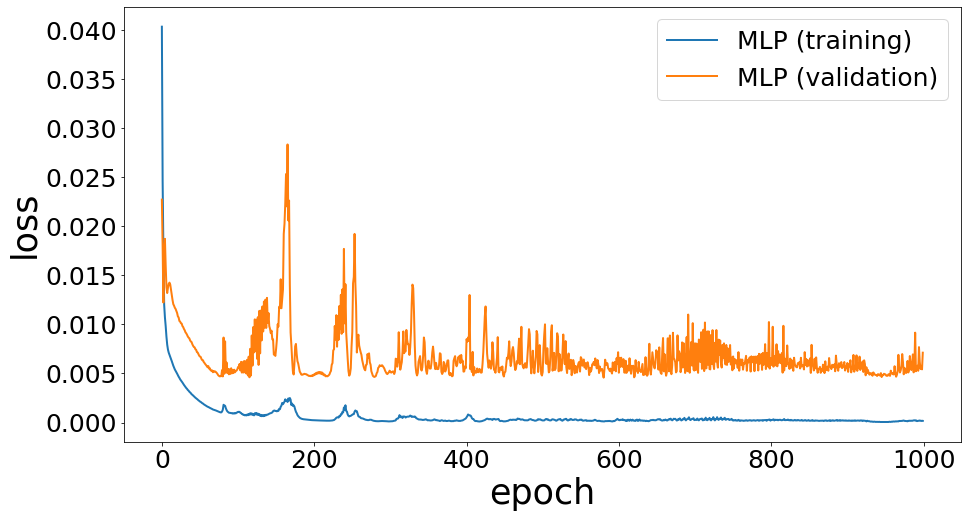

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
x_grid = [i for i in range(total_epoch)]
plt.plot(x_grid, train_loss, linewidth=2)
plt.plot(x_grid, val_loss, linewidth=2)


plt.legend(['MLP (training)', 'MLP (validation)'],  prop={'size': 25})

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel('epoch', fontsize=35)
plt.ylabel('loss', fontsize=35)
plt.show()